## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
print(device)

cuda:0


In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [7]:
len(fmnist_dataset_train)

60000

In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    print(label.unique())
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [9]:
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm1d
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, num_classes)
        )

    def forward(self, inp):
        logits = self.model(inp)
        return logits

In [10]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
       BatchNorm1d-3                  [-1, 200]             400
              ReLU-4                  [-1, 200]               0
           Dropout-5                  [-1, 200]               0
            Linear-6                  [-1, 200]          40,200
       BatchNorm1d-7                  [-1, 200]             400
              ReLU-8                  [-1, 200]               0
           Dropout-9                  [-1, 200]               0
           Linear-10                  [-1, 200]          40,200
      BatchNorm1d-11                  [-1, 200]             400
             ReLU-12                  [-1, 200]               0
           Linear-13                   [-1, 10]           2,010
Total params: 240,610
Trainable params:

Your experiments come here:

In [11]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [12]:
def train_model(model, opt, loss_func, n_epochs, train_loader, test_loader):
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_test_loss = []
        ep_train_accuracy = []
        ep_test_accuracy = []

        model.train(True)
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predict = model(X_batch)
            loss = loss_func(predict, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())
            y_pred = torch.max(predict, dim=1)[1]
            ep_train_accuracy.append(torch.sum(y_pred == y_batch).item() / y_pred.size(0))


        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predict = model(X_batch)
                loss = loss_func(predict, y_batch)
                ep_test_loss.append(loss.item())
                y_pred = torch.max(predict, dim=1)[1]
                accuracy = torch.sum(y_pred == y_batch).item() / y_pred.size(0)
                ep_test_accuracy.append(accuracy)
        print(f'Epoch: {epoch+1}')

        train_loss.append(np.mean(ep_train_loss))
        test_loss.append(np.mean(ep_test_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        test_accuracy.append(np.mean(ep_test_accuracy))

        print(f'tarining loss: {train_loss[-1]:.6f}')
        print(f'test loss: {test_loss[-1]:.6f}')
        print(f'train accuracy: {train_accuracy[-1]:.3f}')
        print(f'test accuracy: {test_accuracy[-1]:.3f}')

    return train_loss, test_loss, train_accuracy, test_accuracy







In [17]:
def plot_train_process(train_loss, test_loss, train_accuracy, test_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(test_loss, label='test')
    axes[0].legend()

    axes[1].set_title('Accuracy')
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(test_accuracy, label='test')
    axes[1].legend()

In [14]:
n_epochs = 25
train_loss, test_loss, train_accuracy, test_accuracy = train_model(model, opt, loss_func, n_epochs, train_loader, test_loader)

Epoch: 1
tarining loss: 0.587075
test loss: 0.428337
train accuracy: 0.785
test accuracy: 0.842
Epoch: 2
tarining loss: 0.464551
test loss: 0.393060
train accuracy: 0.834
test accuracy: 0.856
Epoch: 3
tarining loss: 0.427714
test loss: 0.370234
train accuracy: 0.845
test accuracy: 0.863
Epoch: 4
tarining loss: 0.402431
test loss: 0.398989
train accuracy: 0.853
test accuracy: 0.857
Epoch: 5
tarining loss: 0.384125
test loss: 0.377335
train accuracy: 0.863
test accuracy: 0.867
Epoch: 6
tarining loss: 0.374115
test loss: 0.341407
train accuracy: 0.865
test accuracy: 0.876
Epoch: 7
tarining loss: 0.364696
test loss: 0.341737
train accuracy: 0.868
test accuracy: 0.878
Epoch: 8
tarining loss: 0.353236
test loss: 0.346236
train accuracy: 0.871
test accuracy: 0.873
Epoch: 9
tarining loss: 0.348289
test loss: 0.336757
train accuracy: 0.872
test accuracy: 0.875
Epoch: 10
tarining loss: 0.341176
test loss: 0.331026
train accuracy: 0.877
test accuracy: 0.880
Epoch: 11
tarining loss: 0.334579
test 

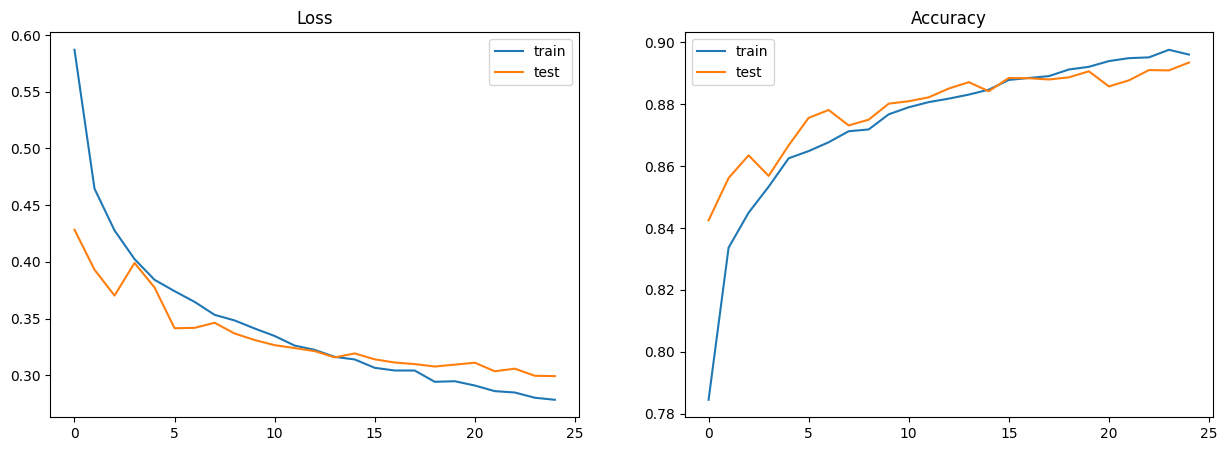

In [18]:
plot_train_process(train_loss, test_loss, train_accuracy, test_accuracy)

In [19]:
def save_checkpoint(path, model, opt):
    state = {
        'model_state': model.state_dict(),
        'optimizer_state': opt.state_dict()}
    torch.save(state, path)
    print(f'model saved to {path}')
def load_checkpoint(path, model, opt):
    state = torch.load(path)
    model.load_state_dict(state['model_state'])
    opt.load_state_dict(state['optimizer_state'])
    print(f'model loaded from {path}')

In [20]:
save_checkpoint('./mnist_model.pth', model, opt)

model saved to ./mnist_model.pth


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [161]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, num_classes)
        )

    def forward(self, inp):
        logits = self.model(inp)
        return logits

In [162]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 200]         100,200
              ReLU-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.89
Estimated Total Size (MB): 1.91
----------------------------------------------------------------


In [163]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [164]:
n_epochs = 40
train_loss, test_loss, train_accuracy, test_accuracy = train_model(model, opt, loss_func, n_epochs, train_loader, test_loader)

Epoch: 1
tarining loss: 0.525953
test loss: 0.428385
train accuracy: 0.809
test accuracy: 0.844
Epoch: 2
tarining loss: 0.395242
test loss: 0.415826
train accuracy: 0.857
test accuracy: 0.853
Epoch: 3
tarining loss: 0.366403
test loss: 0.413756
train accuracy: 0.868
test accuracy: 0.854
Epoch: 4
tarining loss: 0.350524
test loss: 0.390001
train accuracy: 0.871
test accuracy: 0.861
Epoch: 5
tarining loss: 0.340001
test loss: 0.387505
train accuracy: 0.876
test accuracy: 0.865
Epoch: 6
tarining loss: 0.328921
test loss: 0.382508
train accuracy: 0.880
test accuracy: 0.865
Epoch: 7
tarining loss: 0.319457
test loss: 0.414496
train accuracy: 0.884
test accuracy: 0.860
Epoch: 8
tarining loss: 0.317593
test loss: 0.371123
train accuracy: 0.885
test accuracy: 0.869
Epoch: 9
tarining loss: 0.305866
test loss: 0.370174
train accuracy: 0.888
test accuracy: 0.871
Epoch: 10
tarining loss: 0.301374
test loss: 0.366572
train accuracy: 0.890
test accuracy: 0.873
Epoch: 11
tarining loss: 0.297277
test 

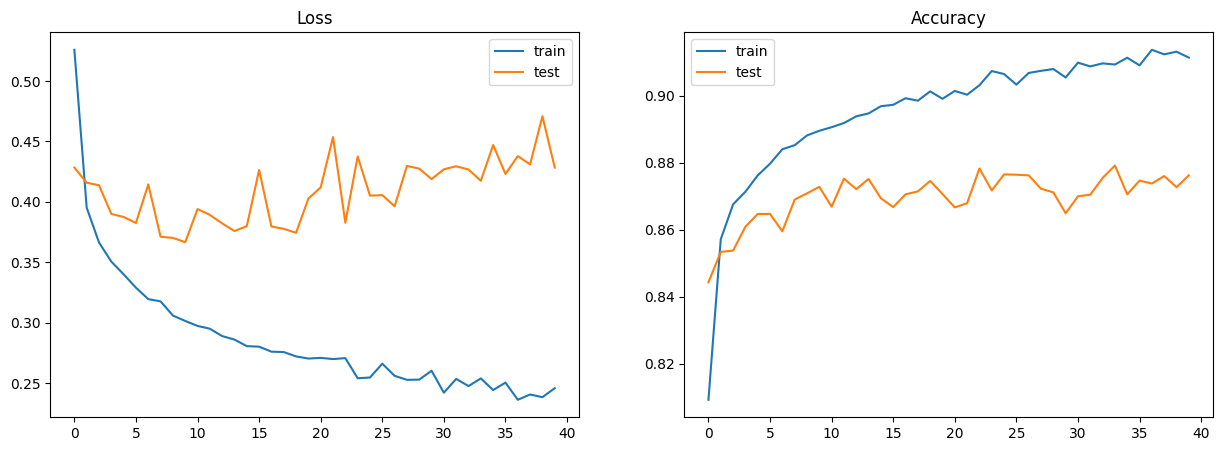

In [165]:
plot_train_process(train_loss, test_loss, train_accuracy, test_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [166]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)

In [167]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
       BatchNorm1d-3                  [-1, 500]           1,000
              ReLU-4                  [-1, 500]               0
            Linear-5                  [-1, 200]         100,200
       BatchNorm1d-6                  [-1, 200]             400
              ReLU-7                  [-1, 200]               0
            Linear-8                   [-1, 10]           2,010
Total params: 496,110
Trainable params: 496,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.89
Estimated Total Size (MB): 1.92
----------------------------------------------------------------


Epoch: 1
tarining loss: 0.456931
test loss: 0.384953
train accuracy: 0.832
test accuracy: 0.858
Epoch: 2
tarining loss: 0.342267
test loss: 0.450499
train accuracy: 0.874
test accuracy: 0.830
Epoch: 3
tarining loss: 0.305367
test loss: 0.354829
train accuracy: 0.886
test accuracy: 0.873
Epoch: 4
tarining loss: 0.279906
test loss: 0.399360
train accuracy: 0.895
test accuracy: 0.859
Epoch: 5
tarining loss: 0.261466
test loss: 0.345711
train accuracy: 0.902
test accuracy: 0.879
Epoch: 6
tarining loss: 0.242564
test loss: 0.321964
train accuracy: 0.909
test accuracy: 0.887
Epoch: 7
tarining loss: 0.228609
test loss: 0.371602
train accuracy: 0.914
test accuracy: 0.868
Epoch: 8
tarining loss: 0.216298
test loss: 0.374060
train accuracy: 0.919
test accuracy: 0.871
Epoch: 9
tarining loss: 0.201088
test loss: 0.355026
train accuracy: 0.924
test accuracy: 0.877
Epoch: 10
tarining loss: 0.194228
test loss: 0.351290
train accuracy: 0.926
test accuracy: 0.881
Epoch: 11
tarining loss: 0.180805
test 

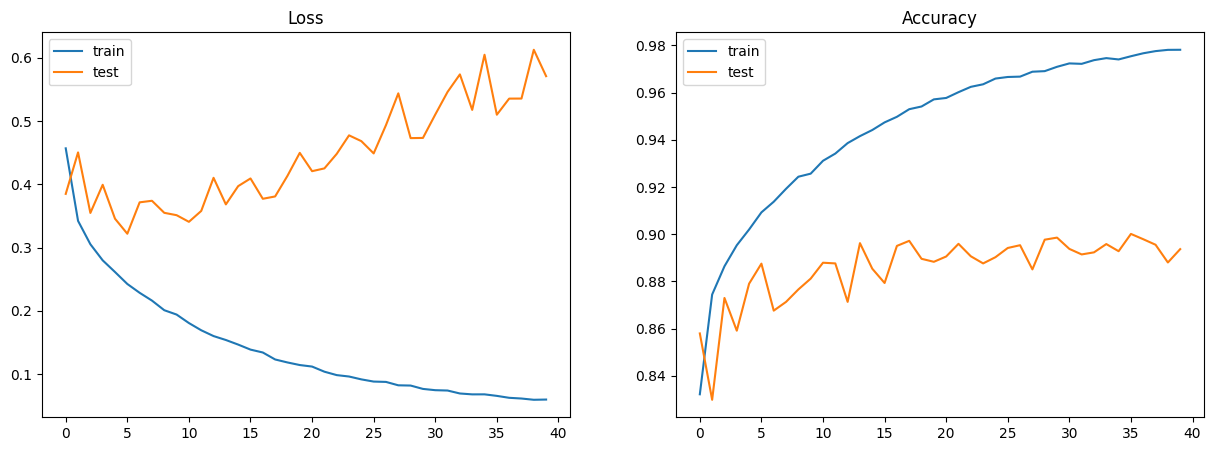

In [168]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
n_epochs = 40
train_loss, test_loss, train_accuracy, test_accuracy = train_model(model, opt, loss_func, n_epochs, train_loader, test_loader)
plot_train_process(train_loss, test_loss, train_accuracy, test_accuracy)

### Conclusions:
_Write down small report with your conclusions and your ideas._

In [170]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(200, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)

torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
           Dropout-4                  [-1, 500]               0
            Linear-5                  [-1, 200]         100,200
              ReLU-6                  [-1, 200]               0
           Dropout-7                  [-1, 200]               0
            Linear-8                   [-1, 10]           2,010
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.89
Estimated Total Size (MB): 1.91
----------------------------------------------------------------


Epoch: 1
tarining loss: 0.780403
test loss: 0.572872
train accuracy: 0.708
test accuracy: 0.789
Epoch: 2
tarining loss: 0.689688
test loss: 0.555255
train accuracy: 0.747
test accuracy: 0.803
Epoch: 3
tarining loss: 0.682584
test loss: 0.592803
train accuracy: 0.754
test accuracy: 0.774
Epoch: 4
tarining loss: 0.678230
test loss: 0.572316
train accuracy: 0.756
test accuracy: 0.792
Epoch: 5
tarining loss: 0.664905
test loss: 0.524870
train accuracy: 0.762
test accuracy: 0.820
Epoch: 6
tarining loss: 0.661247
test loss: 0.503907
train accuracy: 0.765
test accuracy: 0.820
Epoch: 7
tarining loss: 0.646929
test loss: 0.496031
train accuracy: 0.772
test accuracy: 0.828
Epoch: 8
tarining loss: 0.646790
test loss: 0.504232
train accuracy: 0.772
test accuracy: 0.831
Epoch: 9
tarining loss: 0.648073
test loss: 0.481007
train accuracy: 0.771
test accuracy: 0.832
Epoch: 10
tarining loss: 0.638559
test loss: 0.502280
train accuracy: 0.775
test accuracy: 0.810
Epoch: 11
tarining loss: 0.630958
test 

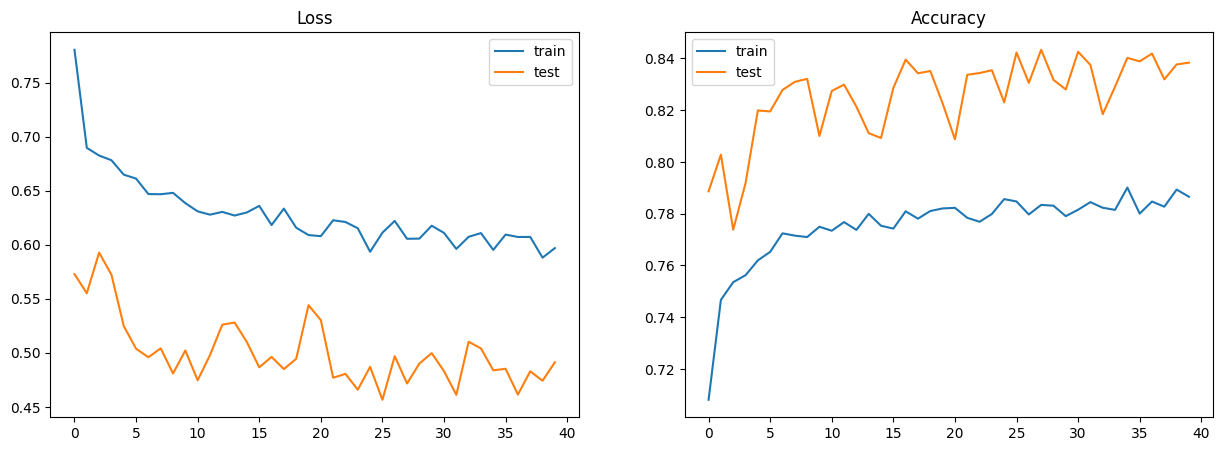

In [171]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
n_epochs = 40
train_loss, test_loss, train_accuracy, test_accuracy = train_model(model, opt, loss_func, n_epochs, train_loader, test_loader)
plot_train_process(train_loss, test_loss, train_accuracy, test_accuracy)

In [172]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(500, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(200, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)

torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
       BatchNorm1d-3                  [-1, 500]           1,000
              ReLU-4                  [-1, 500]               0
           Dropout-5                  [-1, 500]               0
            Linear-6                  [-1, 200]         100,200
       BatchNorm1d-7                  [-1, 200]             400
              ReLU-8                  [-1, 200]               0
           Dropout-9                  [-1, 200]               0
           Linear-10                   [-1, 10]           2,010
Total params: 496,110
Trainable params: 496,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.89
Estimated T

Epoch: 1
tarining loss: 0.530731
test loss: 0.408267
train accuracy: 0.806
test accuracy: 0.849
Epoch: 2
tarining loss: 0.422874
test loss: 0.388533
train accuracy: 0.844
test accuracy: 0.855
Epoch: 3
tarining loss: 0.384398
test loss: 0.369249
train accuracy: 0.857
test accuracy: 0.865
Epoch: 4
tarining loss: 0.362503
test loss: 0.365662
train accuracy: 0.867
test accuracy: 0.863
Epoch: 5
tarining loss: 0.348764
test loss: 0.339226
train accuracy: 0.872
test accuracy: 0.879
Epoch: 6
tarining loss: 0.337821
test loss: 0.327424
train accuracy: 0.876
test accuracy: 0.881
Epoch: 7
tarining loss: 0.324662
test loss: 0.325167
train accuracy: 0.879
test accuracy: 0.881
Epoch: 8
tarining loss: 0.315519
test loss: 0.320992
train accuracy: 0.882
test accuracy: 0.878
Epoch: 9
tarining loss: 0.308300
test loss: 0.313040
train accuracy: 0.885
test accuracy: 0.883
Epoch: 10
tarining loss: 0.301704
test loss: 0.314590
train accuracy: 0.888
test accuracy: 0.885
Epoch: 11
tarining loss: 0.293997
test 

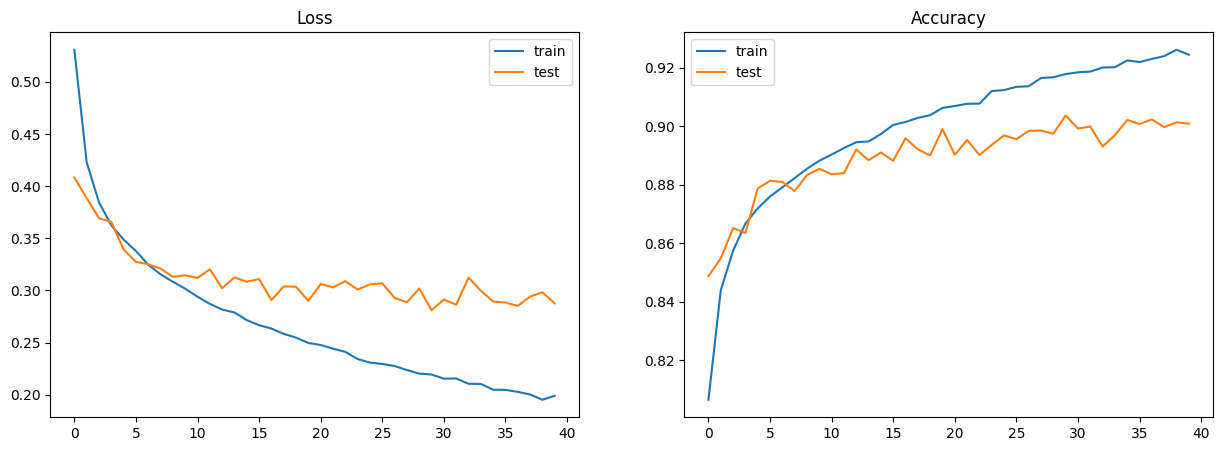

In [173]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
n_epochs = 40
train_loss, test_loss, train_accuracy, test_accuracy = train_model(model, opt, loss_func, n_epochs, train_loader, test_loader)
plot_train_process(train_loss, test_loss, train_accuracy, test_accuracy)